In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from itertools import product
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from gensim.models import Word2Vec

### We are defining some functions for preprocessing, cleaning and data structuring purposes

In [2]:
def clean_text(text):
    ''' 
    Some basic text cleaning phases this function should be applied to the text column
    of the data
    '''
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = set(stopwords.words('english'))
    stop = [w for w in stop if w not in ['not', 'no']]
    text = [x for x in text if (x not in stop)]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    # tokenize the text
    text = text.split()
    return(text)
def apply_cleaning(X_train):
    '''
    With this fonction we apply the clean_text function to the text column of the data
    and it gives as output the cleaned data for each row of the text column
    '''
    X_train = X_train.apply(lambda x: clean_text(x))
    return(X_train)

def tfidf_featured_data(X_train):
    ''''
    No need to explain this function because we gonna use it in the pipeline automatically this function
    used to add tf-idfs columns to the data but I used this to play around with the data and see the
    results of the tfidf vectorizer
    '''

    X_train = apply_cleaning(X_train)
    # add tf-idfs columns
    tfidf = TfidfVectorizer(min_df = 30)
    tfidf_result = tfidf.fit_transform(X_train).toarray()
    tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
    tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
    tfidf_df.index = X_train.index
    X_train = pd.concat([X_train, tfidf_df], axis=1)
    X_train.drop(columns = ['sentences'], inplace = True)
    
    return X_train

def dict2text(dicti):
    '''
    This function is used to convert the dictionary of parameters to a string
    used for GridsearchCV outputs to be saved in a csv file and to be used later 
    on project.
    '''
    text = ''
    for key, value in dicti.items():
        text += str(key) + '=' + str(value) + ' '
    return text

def format_params(params_str):
    '''
    I captured some differences between the parameters of the GridsearchCV output
    to standardize it and make it easy to be used later on the project.
    '''
    # Remove the opening and closing braces and quotes
    params_str = params_str.replace("{", "").replace("}", "").replace("'", "")

    # Replace commas with spaces
    params_str = params_str.replace(", ", " ")

    # Replace colons with equals signs
    params_str = params_str.replace(":", "=")

    # Remove spaces around equals signs
    params_str = params_str.replace("= ", "=").replace(" =", "=")

    return params_str

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def roc_auc(test, y_pred):
    # Assuming y_true contains the true labels (0 or 1) and y_pred contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(test.values, y_pred)
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def review_to_vector(review, word_embedding_model):
    vectors = []
    for word in review:
        if word in word_embedding_model.wv:
            vectors.append(word_embedding_model.wv[word])
    
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_embedding_model.vector_size)

##### As a baseline model Naive Bayes is the perfect model. It is time efficient and good performing. Also there are not much parameters to play around so we are able to focus on feature creation phase. 

In [3]:
train = pd.read_csv("train_data_400k_randomsample.csv")
train["sentences"] = apply_cleaning(train["sentences"])

In [4]:
#create the word embeddings
sentences = train["sentences"].values  # List of sentences or list of word lists
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

In [5]:
model.wv.similar_by_word("good")

[('great', 0.8321499824523926),
 ('decent', 0.7864553332328796),
 ('bad', 0.747329831123352),
 ('ok', 0.7302947044372559),
 ('nice', 0.6912297010421753),
 ('okay', 0.6786788105964661),
 ('excellent', 0.6511772871017456),
 ('like', 0.6181908249855042),
 ('solid', 0.6093428730964661),
 ('however', 0.5964057445526123)]

In [ ]:
model.wv.similar_by_word("bad")

[('terrible', 0.7627414464950562),
 ('horrible', 0.7502744793891907),
 ('good', 0.7465962171554565),
 ('awful', 0.709083616733551),
 ('lame', 0.6495473384857178),
 ('lousy', 0.6475998759269714),
 ('poor', 0.6453679203987122),
 ('ok', 0.6373372077941895),
 ('crappy', 0.6332535147666931),
 ('decent', 0.6305558681488037)]

#### Trying different settings of parameters. We couldn't use the embeddings in a gridsearch pipeline so we created the code cells below to manually implement the hyperparameter tunning phase. Our kernel crashed several times, because of that we put the outputs into markdown cells below. Due to kernel crashes, other cells are continues the param settings where the code left before crash. Some kernels crashed before evaluating some parameters we didn't continue training it since the some of the results were not even close to competing with best parameter setting obtained. This time fixed train validation splits had been used due to embedding creation difficulties and kernel crashes.

In [12]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train["sentences"], train["labels"], test_size=0.1, random_state=42)

sentences = X_train.values
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

# Define the hyperparameters to tune
embedding_sizes = [300]
window_sizes = [3, 7]
min_count_values = [1, 5]
svm_C_values = [0.1, 1, 10]

best_score = 0
best_embedding_size = None
best_window_size = None
best_min_count = None
best_svm_params = {}

# Loop over different hyperparameter combinations for Word2Vec
for embedding_size in embedding_sizes:
    for window_size in window_sizes:
        for min_count in min_count_values:
            print(f'Embedding size: {embedding_size} / Window size: {window_size} / Min count: {min_count}')
            
            # Train the Word2Vec model
            model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, min_count=min_count)

            X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
            X_val_vectors = np.array([review_to_vector(review, model) for review in X_val])
            
            # Perform hyperparameter tuning for SVM
            for C in svm_C_values:
                print(f'SVM regularization parameter: {C}')
                svm = LinearSVC(C=C)
                svm.fit(X_train_vectors, y_train)
                val_score = accuracy_score(y_val, svm.predict(X_val_vectors))
                print(f'Validation score: {val_score}')
                if val_score > best_score:
                        best_score = val_score
                        best_embedding_size = embedding_size
                        best_window_size = window_size
                        best_min_count = min_count
                        best_svm_params['C'] = C

# Print the best hyperparameters and the corresponding score
print("Best embedding size:", best_embedding_size)
print("Best window size:", best_window_size)
print("Best min count:", best_min_count)
print("Best SVM parameters:", best_svm_params)
print("Best score:", best_score)

Embedding size: 300 / Window size: 3 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.878175
SVM regularization parameter: 1


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.8782
SVM regularization parameter: 10


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.875125
Embedding size: 300 / Window size: 3 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.878525
SVM regularization parameter: 1


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.8785
SVM regularization parameter: 10


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.8786
Embedding size: 300 / Window size: 7 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.88205
SVM regularization parameter: 1


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.88195
SVM regularization parameter: 10


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.84475
Embedding size: 300 / Window size: 7 / Min count: 5
SVM regularization parameter: 0.1


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.882725
SVM regularization parameter: 1


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Validation score: 0.882875
SVM regularization parameter: 10
Validation score: 0.881
Best embedding size: 300
Best window size: 7
Best min count: 5
Best SVM parameters: {'C': 1}
Best score: 0.882875


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Embedding size: 300 / Window size: 3 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.878175
SVM regularization parameter: 1
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.8782
SVM regularization parameter: 10
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.875125
Embedding size: 300 / Window size: 3 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.878525
SVM regularization parameter: 1
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.8785
SVM regularization parameter: 10
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.8786
Embedding size: 300 / Window size: 7 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.88205
SVM regularization parameter: 1
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.88195
SVM regularization parameter: 10
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.84475
Embedding size: 300 / Window size: 7 / Min count: 5
SVM regularization parameter: 0.1
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.882725
SVM regularization parameter: 1
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Validation score: 0.882875
SVM regularization parameter: 10
Validation score: 0.881
Best embedding size: 300
Best window size: 7
Best min count: 5
Best SVM parameters: {'C': 1}
Best score: 0.882875
/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train["sentences"], train["labels"], test_size=0.1, random_state=42)

sentences = X_train.values
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

# Define the hyperparameters to tune
embedding_sizes = [300]
window_sizes = [3, 7]
min_count_values = [1, 5]
svm_C_values = [0.1, 1, 10]

best_score = 0
best_embedding_size = None
best_window_size = None
best_min_count = None
best_svm_params = {}

# Loop over different hyperparameter combinations for Word2Vec
for embedding_size in embedding_sizes:
    for window_size in window_sizes:
        for min_count in min_count_values:
            print(f'Embedding size: {embedding_size} / Window size: {window_size} / Min count: {min_count}')
            
            # Train the Word2Vec model
            model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, min_count=min_count)

            X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
            X_val_vectors = np.array([review_to_vector(review, model) for review in X_val])
            
            # Perform hyperparameter tuning for SVM
            for C in svm_C_values:
                print(f'SVM regularization parameter: {C}')
                svm = LinearSVC(C=C, penalty='l1', dual=False)
                svm.fit(X_train_vectors, y_train)
                val_score = accuracy_score(y_val, svm.predict(X_val_vectors))
                print(f'Validation score: {val_score}')
                if val_score > best_score:
                        best_score = val_score
                        best_embedding_size = embedding_size
                        best_window_size = window_size
                        best_min_count = min_count
                        best_svm_params['C'] = C

# Print the best hyperparameters and the corresponding score
print("Best embedding size:", best_embedding_size)
print("Best window size:", best_window_size)
print("Best min count:", best_min_count)
print("Best SVM parameters:", best_svm_params)
print("Best score:", best_score)

Embedding size: 100 / Window size: 3 / Min count: 1

SVM regularization parameter: 0.1
Validation score: 0.864925

SVM regularization parameter: 1
Validation score: 0.865025

SVM regularization parameter: 10
Validation score: 0.865025

Embedding size: 100 / Window size: 3 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.864825

SVM regularization parameter: 1
Validation score: 0.864475

SVM regularization parameter: 10
Validation score: 0.864425

Embedding size: 100 / Window size: 7 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.8725

SVM regularization parameter: 1
Validation score: 0.872425

SVM regularization parameter: 10
Validation score: 0.872375

Embedding size: 100 / Window size: 7 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.874

SVM regularization parameter: 1
Validation score: 0.8741

SVM regularization parameter: 10
Validation score: 0.87405

Embedding size: 300 / Window size: 3 / Min count: 1
SVM regularization parameter: 0.1

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train["sentences"], train["labels"], test_size=0.1, random_state=42)

sentences = X_train.values
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

# Define the hyperparameters to tune
embedding_sizes = [100, 300]
window_sizes = [3, 7]
min_count_values = [1, 5]
svm_C_values = [0.1, 1, 10]

best_score = 0
best_embedding_size = None
best_window_size = None
best_min_count = None
best_svm_params = {}

# Loop over different hyperparameter combinations for Word2Vec
for embedding_size in embedding_sizes:
    for window_size in window_sizes:
        for min_count in min_count_values:
            print(f'Embedding size: {embedding_size} / Window size: {window_size} / Min count: {min_count}')
            
            # Train the Word2Vec model
            model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, min_count=min_count)

            X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
            X_val_vectors = np.array([review_to_vector(review, model) for review in X_val])
            
            # Perform hyperparameter tuning for SVM
            for C in svm_C_values:
                print(f'SVM regularization parameter: {C}')
                svm = LinearSVC(C=C, penalty='l2', dual=False, loss='hinge')
                svm.fit(X_train_vectors, y_train)
                val_score = accuracy_score(y_val, svm.predict(X_val_vectors))
                print(f'Validation score: {val_score}')
                if val_score > best_score:
                        best_score = val_score
                        best_embedding_size = embedding_size
                        best_window_size = window_size
                        best_min_count = min_count
                        best_svm_params['C'] = C

# Print the best hyperparameters and the corresponding score
print("Best embedding size:", best_embedding_size)
print("Best window size:", best_window_size)
print("Best min count:", best_min_count)
print("Best SVM parameters:", best_svm_params)
print("Best score:", best_score)

In [ ]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train["sentences"], train["labels"], test_size=0.1, random_state=42)

sentences = X_train.values
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

# Define the hyperparameters to tune
embedding_sizes = [300]
window_sizes = [3, 7]
min_count_values = [1, 5]
svm_C_values = [0.1, 1, 10]

best_score = 0
best_embedding_size = None
best_window_size = None
best_min_count = None
best_svm_params = {}

# Loop over different hyperparameter combinations for Word2Vec
for embedding_size in embedding_sizes:
    for window_size in window_sizes:
        for min_count in min_count_values:
            print(f'Embedding size: {embedding_size} / Window size: {window_size} / Min count: {min_count}')
            
            # Train the Word2Vec model
            model = Word2Vec(sentences, vector_size=embedding_size, window=window_size, min_count=min_count)

            X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
            X_val_vectors = np.array([review_to_vector(review, model) for review in X_val])
            
            # Perform hyperparameter tuning for SVM
            for C in svm_C_values:
                print(f'SVM regularization parameter: {C}')
                svm = SVC(C=C, kernel='rbf')
                svm.fit(X_train_vectors, y_train)
                val_score = accuracy_score(y_val, svm.predict(X_val_vectors))
                print(f'Validation score: {val_score}')
                if val_score > best_score:
                        best_score = val_score
                        best_embedding_size = embedding_size
                        best_window_size = window_size
                        best_min_count = min_count
                        best_svm_params['C'] = C

# Print the best hyperparameters and the corresponding score
print("Best embedding size:", best_embedding_size)
print("Best window size:", best_window_size)
print("Best min count:", best_min_count)
print("Best SVM parameters:", best_svm_params)
print("Best score:", best_score)

Embedding size: 300 / Window size: 3 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.5742574257425742
SVM regularization parameter: 1
Validation score: 0.5841584158415841
SVM regularization parameter: 10
Validation score: 0.6831683168316832
Embedding size: 300 / Window size: 3 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.5742574257425742
SVM regularization parameter: 1
Validation score: 0.5742574257425742
SVM regularization parameter: 10
Validation score: 0.5148514851485149
Embedding size: 300 / Window size: 7 / Min count: 1
SVM regularization parameter: 0.1
Validation score: 0.5742574257425742
SVM regularization parameter: 1
Validation score: 0.5742574257425742
SVM regularization parameter: 10
Validation score: 0.5742574257425742
Embedding size: 300 / Window size: 7 / Min count: 5
SVM regularization parameter: 0.1
Validation score: 0.5742574257425742
SVM regularization parameter: 1
Validation score: 0.5742574257425742
SVM regularization par

#### Let's try our best performing parameter 

Best embedding size: 300
Best window size: 7
Best min count: 5
Best SVM parameters: {'C': 1}
(l2, square hinge)
Best score: 0.882875

Note: This parameter setting is the best one for the tf-idf svm as well!

In [3]:
train = pd.read_csv("train_data_400k_randomsample.csv")
train["sentences"] = apply_cleaning(train["sentences"])
sentences = train["sentences"].values
X_train = train["sentences"]
test= pd.read_csv("test_data_44k.csv")
test["sentences"] = apply_cleaning(test["sentences"])
X_test = test["sentences"]
y_test = test['labels']
y_train = train["labels"]

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=300, window=7, min_count=5)

X_train_vectors = np.array([review_to_vector(review, model) for review in X_train])
X_test_vectors = np.array([review_to_vector(review, model) for review in X_test])

# Train the svm model
svm = LinearSVC(C=1, penalty='l2', loss="squared_hinge")
svm.fit(X_train_vectors, y_train)

# Evaluate the model
y_pred = svm.predict(X_test_vectors)
y_pred_probs = svm.decision_function(X_test_vectors)  # Prediction probabilities

# Print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy score:", accuracy)
print("F1 score:", f1)
print("ROC AUC score:", roc_auc)
print("Precision score:", precision)
print("Recall score:", recall)

# Print predicted probabilities
print("Prediction probabilities:")
print(y_pred_probs)

Accuracy score: 0.8841136363636364
F1 score: 0.8837039571216787
ROC AUC score: 0.8841102212204244
Precision score: 0.8847734746072342
Recall score: 0.8826370221877989
Prediction probabilities:
[ 0.46682757 -0.70665679 -1.62412939 ...  2.76850301 -1.93664407
  0.45875112]


/home/ege/miniconda3/envs/dataminingv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [4]:
pd.DataFrame(y_pred).to_csv("y_pred_embeddings.csv")

AUC: 0.9510


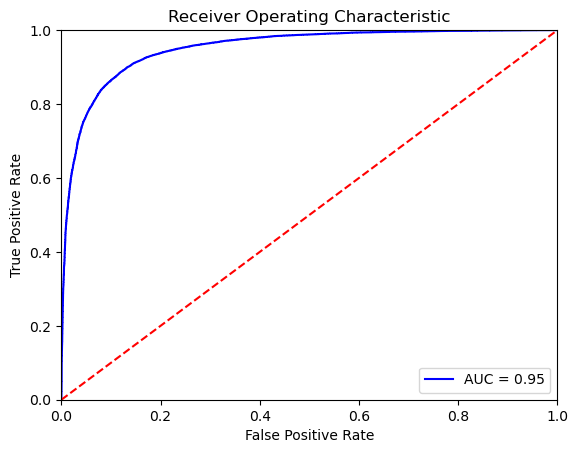

In [23]:
def evaluate_roc_probs(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true),)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    fpr, tpr, thresholds = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')

    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# Evaluate ROC curve
evaluate_roc_probs(y_pred_probs, test["labels"].values)

#### After selecting the best parameters our model with 400k train data and 44k test data being evaluated. And confusion matrix has been produced. 

#### Error Analysis

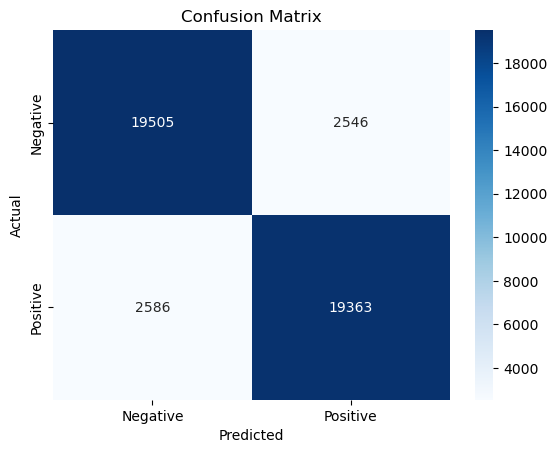

In [13]:
#Show confusion matrix
cm = confusion_matrix(test["labels"], y_pred)
cm = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Negative", "Positive"])
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


<AxesSubplot: xlabel='labels'>

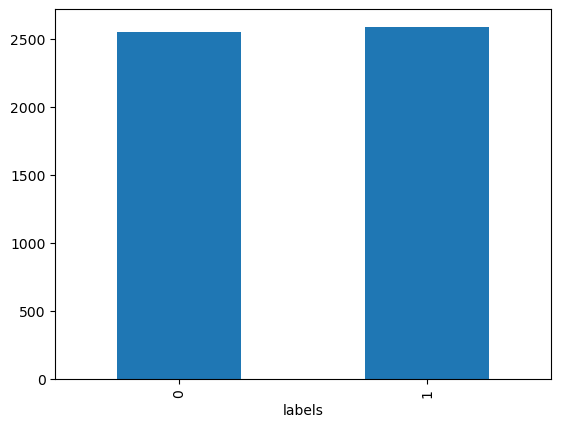

In [17]:
test = pd.read_csv(("test_data_44k.csv"))
test["y_pred"] = y_pred
test[test["labels"] != test["y_pred"]].groupby('labels').count()["sentences"].plot(kind="bar")

In [18]:
# Select the 5 random observations from the test set where model failed to predict the label correctly
pd.set_option('display.max_colwidth', None)
# test[test["labels"] != test["y_pred"]].sample(5)
indices = [27443, 29215, 14827 ,18809 ,12847]
test[test.index.isin(indices)]

,sentences,labels,y_pred
12847,"a good book: this book really hit the mark with the right balance of theory and practical application. i've waded through more than a few technical books on tube radio theory and restoration, and this one, though not as detailed as a textbook, is clearly the place to start.however, the section on troubleshooting was extremely limited. experience indicates that after following the steps recommended in the book between 10 and 20 percent of restored radios will still have some type of problem. most individuals learning the process for repairing tube radios will be seeking practical guidance for identifying possible sources of these problems and their potential solutions. maybe troubleshooting will be the subject of mr. mcwhorter's next book.",1,0
14827,"here is just a sample!! check it out!!: i love this album and pray that someone contacts me so that i can get a copy of the cd or even tape! amazon...please get this so that all of us who would like a copy can get it! until then...here is ""feel like going on"" the song![...]",1,1
18809,"still in the box: i don't really know how the product is. after reading more detailed information included with the product, it says not recommended for the pool because the clorine could effect/shorten the product life. it seems that the ad shows the coolaroo shade being used next to the pool. and that's what we bought it for. not sure what to do with them now - still siting in the box next to the door gathering dust.... oh, well. i'm sure its a great product, just not for us.",0,1
27443,"leaves the readers hungry for more.: it's weird really how i got so into this book. one of my friends who just so happened read the book was begging me to read it. now, don't get me wrong i love fantasy stories especially ones that are about these blood suckers but after hearing my friend's summary of it i don't know i just felt uninterested.pffft...boy was i glad my friend's the persisting type. she practically lunged the book at me. so as to not annoy her more, i read her copy of the book and i found myself entralled by it. i could not stop reading it!after finishing it i felt saddened that it was finished. i wanted more! i wanted to know what happened next.i gave the book back to my friend and straight away got myself a copy of twilight. it's really that good. i love it.trust me no matter how 'off' the summary might seem like you would not feel dissatisfied by its contents.",1,0
29215,"emotionally-distant author: for a memoir, the author is very removed from the experiences she writes about. she conveys little if any emotion about what must have been a very lonely and often frightening existance (especially given her age) in a strange land with a mad and eventually abusive husband, a young child who was often extremely sick and with the responsibilites of running a hacienda. although her writing is beautiful at times, the author never really connected with me.",0,1


In [1]:
pd.set_option('display.max_colwidth', None)
test[test["labels"] != test["y_pred"]].sample(5)

NameError: name 'pd' is not defined